# Experiment Comparison

The goal of this notebook is to provide a mechanism to review and compare experiments: the cfg, the metrics, and the outcome.

## I. Setup

In [231]:
# project imports
import env
from data.voxels import read_voxel_array, convert_voxels_to_stl
from data.stl import plot_mesh
from utils import PROJECT_ROOT, read_json_data, flatten_dict, np_recon_loss
from models import MODEL_DIR


# python & package imports
from collections import defaultdict
import pandas as pd
import json
import os


# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2


model_dir = os.path.join(MODEL_DIR, 'voxel_vaegan1', 'modelnet10')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## II. Experiments

Use this section to save the paths to the experiment model cfgs and checkpoints to be used in later review/comparison sections.

In [232]:
# Experiments

# 500 epochs, just bird
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-30-02/model_epoch-499.ckpt'
# 500 epochs, just bird, increased recon weight
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-38-41/model_epoch-499.ckpt'
# 500 epochs, just bird, dropout 0.8
# early stop
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-44-48/model_epoch-199.ckpt'
# later stop
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-44-48/model_epoch-499.ckpt'
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_10-22-19/model_epoch-49.ckpt'

# first run with modelnet10
# {'reconstruction_loss': 808.4996337890625, 'dis_loss': -999.0, 'kl_divergence': 488.078369140625, 'dec_loss': -999.0, 'elapsed_time': 43.02408063411713, 'enc_loss': 261.9851379394531}

### vae
best_sofa = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-15_10-33-37'
toilet_and_sofa = '/home/jcworkma/jack/3d-form/models/voxel_vaegan1/modelnet10/2019-03-15_12-26-16'
return_to_vae = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_08-11-20'
return_toilet = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_08-20-39'
vae_200epochs = os.path.join(MODEL_DIR, 'voxel_vae_toilet_200epochs_1')
# too high of a kl makes a box-like reconstruction with too high of a mean_decoded_output
vae_200epochs_100kl = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-24_15-16-59'
vae_200epochs_10kl = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-25_01-43-20'
vae_200epochs_p1kl = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-25_11-05-00'
vae_200epochs_p1kl_1000latent = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-26_05-10-08'
vae_bathtub_toilet = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-26_17-02-56'
vae_toilet_nightstand_monitor = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-27_05-27-14'
vae_full_index = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-28_15-09-00'
vae_modelnet10 = '/home/jcworkma/jack/3d-form/models/voxel_vae_modelnet10_200epochs_1'

### vaegan
vaegan_sofa13 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-16_13-37-24/model_epoch-13.ckpt'
vaegan_sofa = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-16_13-37-24/model_epoch-5.ckpt'
vaegan_decent_toilets_21 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-17_08-40-29'
vaegan_long_toilets = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-18_13-12-53'
vaegan_new_losses = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-19_19-31-20'
vaegan_1024_filter_discr = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-20_09-39-05/'
vaegan_logless_loss = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-22_16-01-54'
vaegan_reuse_check = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_03-48-39'
vaegan_reuse_check2 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_04-00-49'
vaegan_reuse_check3 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_04-06-01'
vaegan_reuse_check4 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_04-09-04'


## III. Reconstruction Test
Here we can reload a model and experiment with reconstructions.

In [311]:
# project imports
from models.voxel_vaegan import VoxelVaegan
from data.modelnet10 import ModelNet10
from data.thingi10k import Thingi10k
from data.voxels import plot_voxels
from utils import read_json_data


# python & package projects
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

# model to use for reconstruction
model_root = os.path.join(PROJECT_ROOT, vae_modelnet10)
model_cfg = read_json_data(os.path.join(model_root, 'cfg.json'))
model_ckpt = os.path.join(model_root, 'model_epoch-124.ckpt')
#model_ckpt = os.path.join(model_root, 'model_epoch-_end.ckpt')

# restore the model from ckpt
vaegan = VoxelVaegan.initFromCfg(model_cfg)
vaegan.restore(model_ckpt)

INFO:tensorflow:Restoring parameters from /home/jcworkma/jack/3d-form/models/voxel_vae_modelnet10_200epochs_1/model_epoch-124.ckpt


INFO:tensorflow:Restoring parameters from /home/jcworkma/jack/3d-form/models/voxel_vae_modelnet10_200epochs_1/model_epoch-124.ckpt


### III. A. From Dataset Example

chair_0283_32_x0_z0.binvox


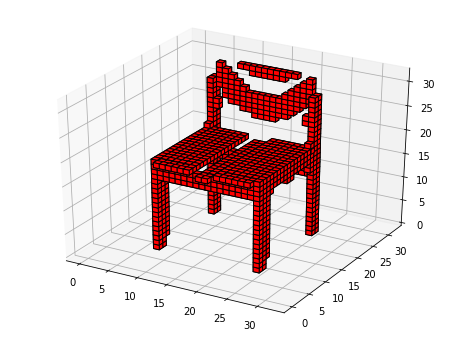

In [324]:
def get_example(random=True, category=None, name=None, plot=True):
    """
    Returns an example from the dataset and optionally plots
    
    Args:
        random: bool, if True, will get random voxel
        name: tuple (category, dataset, name), will return named example
        
    Returns:
        training_input: np.array, exact voxel in original dims
        training_example: np.array, voxel in reshaped-for-model dims
    """
    dataset_class = model_cfg.get('dataset').get('class')
    dataset_index = model_cfg.get('dataset').get('index')
    dataset_categories = model_cfg.get('dataset').get('categories', None)
    if dataset_class == 'Thingi10k':
        # get an stl example
        thingi = Thingi10k.init10k()
        stl_example = thingi.get_stl_path(stl_id=126660)
        training_input = thingi.get_voxels(32, stl_file=stl_example)
    elif dataset_class == 'ModelNet10':
        modelnet = ModelNet10.initFromIndex(dataset_index)
        modelnet.filter_x_z(0, 0)
        if dataset_categories:
            modelnet.filter_categories(dataset_categories)
            print(modelnet.df.category.unique())
        if category:
            modelnet.filter_categories([category])
        if name:
            training_input = modelnet.get_voxels(name[0], name[1], name[2])
        elif random:
            name, training_input = modelnet.get_random_voxels(32)
        print(name)

    #training_input = modelnet.get_voxels('toilet', 'train', 'toilet_0056_32_x0_z0.binvox')
    #training_input = modelnet.get_voxels('bathtub', 'train', 'bathtub_0082_32_x0_z0.binvox')

    if plot:
        plot_voxels(training_input)
    training_example = np.reshape(training_input, (-1, 32, 32, 32, 1))
    
    return training_input, training_example


training_input, training_example = get_random_example()

# bad voxels:
# toilet_0211_32_x0_z3.binvox is an empty array!
# bed_0010_32_x0_z0.binvox

In [325]:
recon = vaegan.reconstruct(training_example)
recon = np.reshape(recon, [32, 32, 32])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))
print('loss: ', np_recon_loss(training_input, recon))

max:  0.99971026
min:  0.0
mean:  0.059536822
loss:  0.0028395108


<module 'matplotlib.pyplot' from '/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/matplotlib/pyplot.py'>

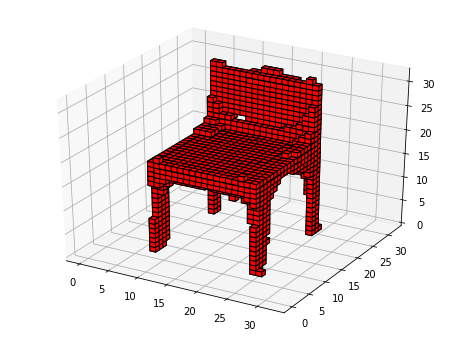

In [326]:
recon_threshold = recon > .9
plot_voxels(recon_threshold)

### III. B. From Latent Vector

Thank you: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb

In [306]:
latent_vector = vaegan.random_latent_vector(mu=.5, sig=.7)
recon = vaegan.latent_recon(latent_vector)
recon = np.reshape(recon, [32, 32, 32])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))

max:  0.9999989
min:  0.0
mean:  0.040056363


<module 'matplotlib.pyplot' from '/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/matplotlib/pyplot.py'>

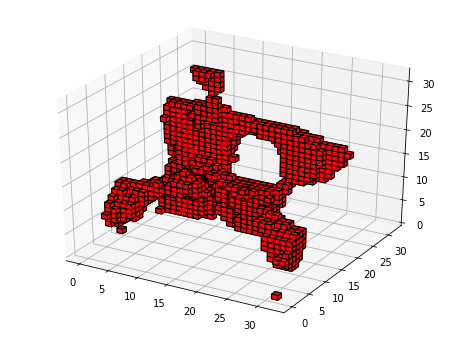

In [308]:
recon_threshold = recon > .2
plot_voxels(recon_threshold)

## III. C. From External Example

In [309]:
ext_example = os.path.join(PROJECT_ROOT, 'data/external/Bear_10.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/HORSE.binvox')
ext_voxels = read_voxel_array(ext_example).data
plot_voxels(ext_voxels)
ext_voxels = np.reshape(ext_voxels, (-1, 32, 32, 32, 1))

FileNotFoundError: [Errno 2] No such file or directory: '/home/jcworkma/jack/3d-form/src/../data/external/Bear_10.binvox'

In [176]:
recon = vaegan.reconstruct(ext_voxels)
recon = np.reshape(recon, [32, 32, 32])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))

max:  0.99994326
min:  0.0
mean:  0.14300275


<module 'matplotlib.pyplot' from '/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/matplotlib/pyplot.py'>

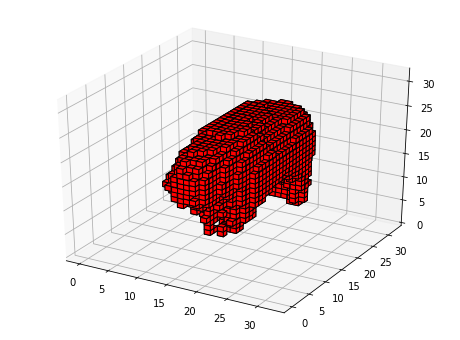

In [178]:
recon_threshold = recon > .9
plot_voxels(recon_threshold)

## IV. Object Mashup

sofa_0257_32_x0_z0.binvox
monitor_0011_32_x0_z0.binvox


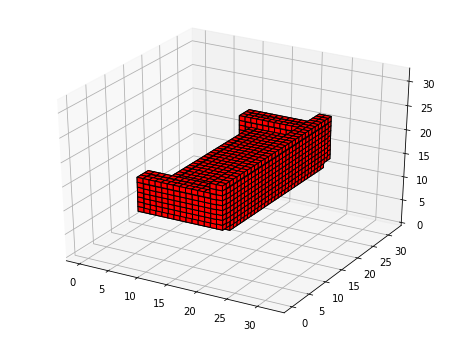

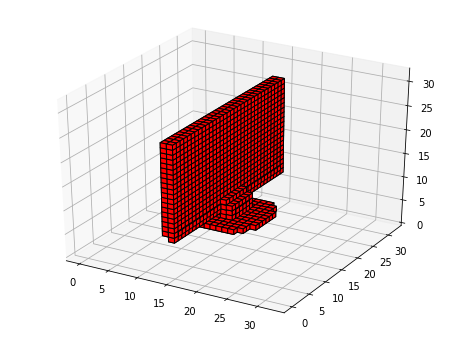

In [260]:
#input1, ex1 = get_example(name=('table', 'train', 'table_0272_32_x0_z0.binvox'))
input1, ex1 = get_example()
input2, ex2 = get_example()

In [261]:
mashed = vaegan.mashup(ex1, ex2)
print(mashed.shape)

(10, 32, 32, 32, 1)


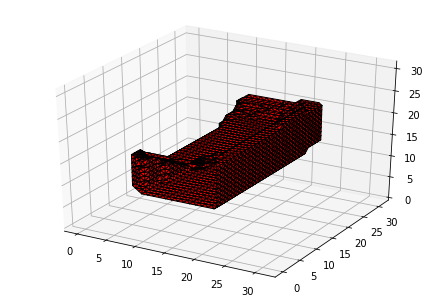

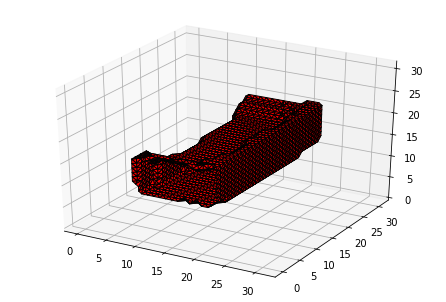

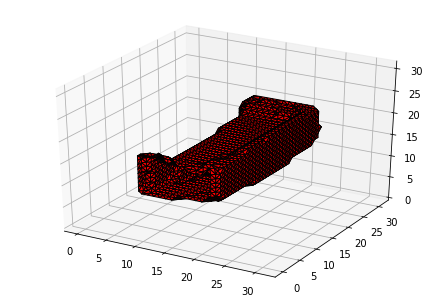

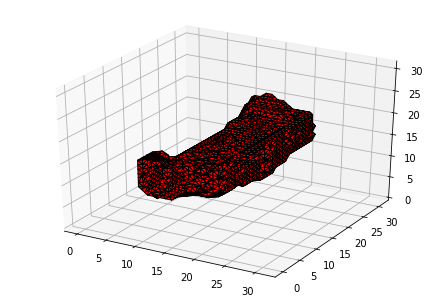

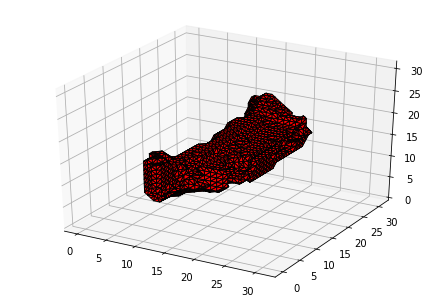

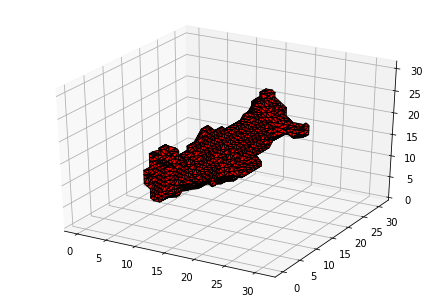

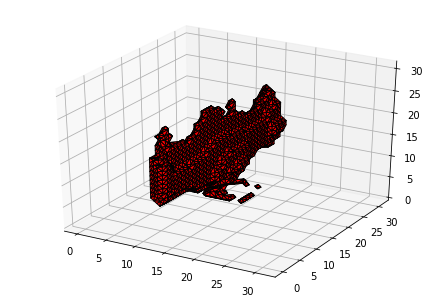

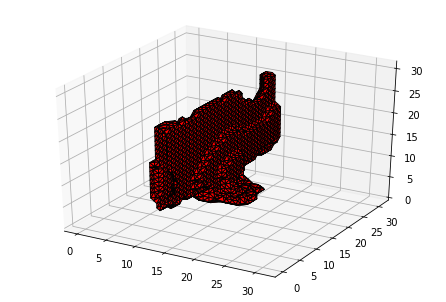

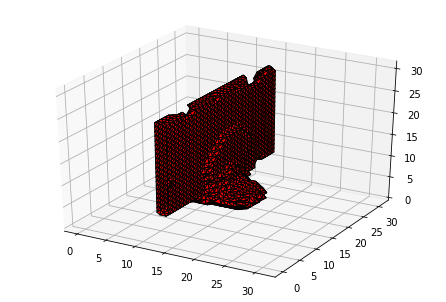

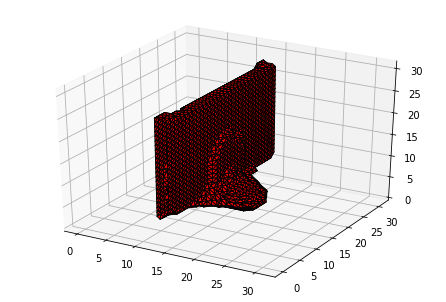

In [262]:
for m in mashed:
    m = np.reshape(m, (32, 32, 32))
    #print('max: ', np.max(m))
    #print('min: ', np.min(m))
    #print('mean: ', np.mean(m))
    m_threshold = m > .9
    #plot_voxels(m_threshold)
    stl_data = convert_voxels_to_stl(m_threshold)
    plot_mesh(stl_data)

## V. Model Leaderboard

This section iterates through all directories in the model dir and extracts their loss values. We can use this section to review past experiments and see which ones yielded positive results.

In [173]:
scores = dict()
for m in os.listdir(model_dir):
    name = m
    metrics_json = os.path.join(model_dir, m, 'metrics.json')
    #print(metrics_json)
    #if os.path.exists(metrics_json):
    #    df = pd.read_json(metrics_json, orient='values')
    #    break
    metrics_dict = read_json_data(metrics_json)
    if metrics_dict:
        # assuming only keys are epoch\d+
        keys = [int(key.replace('epoch', '')) for key in metrics_dict.keys()]
        last_epoch = sorted(keys)[-1]
        last_key = 'epoch{}'.format(last_epoch)
        scores[name] = metrics_dict[last_key]
        scores[name]['epoch'] = last_epoch

df = pd.DataFrame.from_dict(scores, orient='index')

In [74]:
df.sort_values('enc_loss')

,dis_loss,reconstruction_loss,kl_divergence,dec_loss,elapsed_time,epoch,enc_loss,ll_loss
2019-03-22_16-01-54,0.002769,2.335672,3.352761e-08,0.002977,622.948439,19,0.000211,2.078947e+00
2019-03-23_04-26-53,0.025842,1.973222,7.585932e-04,0.177429,184.921859,5,0.227446,1.515868e+02
2019-03-20_09-39-05,0.000000,0.534304,2.374873e-07,8.045086,1266.072246,39,8.045110,8.045086e+04
2019-03-18_13-12-53,5.041445,0.266909,6.988272e-04,11.406572,1135.887282,99,11.474426,1.140454e+04
2019-03-17_08-40-29,4.714500,0.056535,2.244420e-02,45.475174,273.749028,21,15.197393,1.295297e+04
2019-03-21_12-22-09,0.000000,0.412828,1.419442e-03,15.351218,1247.157203,39,15.493162,1.535122e+05
2019-03-19_10-02-38,6.339924,0.107949,8.224614e-02,80.328392,113.116486,9,19.571060,1.134644e+04
2019-03-17_15-32-59,5.186166,0.109524,7.946533e-02,85.769615,906.537507,79,24.990257,1.704372e+04
2019-03-19_14-25-04,6.330705,0.099275,1.969671e-01,82.684891,112.582602,9,33.104237,1.340753e+04
2019-03-15_10-33-37,-999.000000,352.732208,5.041918e+02,-999.000000,75.421927,9,123.401489,NaN


## VI. Config Comparison

Use this section to compare configs between two experiments. This can be useful when determining what yielded positive results in previous runs.

In [199]:
cfg1 = read_json_data(os.path.join(vae_200epochs, 'cfg.json'), verbose=True)
cfg2 = read_json_data(os.path.join(vae_200epochs_10kl, 'cfg.json'), verbose=True)
assert isinstance(cfg1, dict)
assert isinstance(cfg2, dict)

# flatten dict structure then bring into pandas for a pretty view
cfg1 = flatten_dict(cfg1)
cfg2 = flatten_dict(cfg2)
df1 = pd.DataFrame.from_dict(cfg1, orient='index', columns=['cfg1'])
df2 = pd.DataFrame.from_dict(cfg2, orient='index', columns=['cfg2'])
dff = pd.concat([df1, df2], axis=1, sort=False)
dff['diff'] = dff.cfg1 == dff.cfg2
dff

,cfg1,cfg2,diff
generator/verbose,True,True,True
model/batch_size,128,128,True
model/dis_lr,0.0001,0.0001,True
dataset/class,ModelNet10,ModelNet10,True
model/launch_tensorboard,True,True,True
model/no_gan,True,True,True
model/voxels_dim,32,32,True
dataset/index,/home/jcworkma/jack/3d-form/src/../data/proces...,/home/jcworkma/jack/3d-form/src/../data/proces...,True
model/input_repeats,1,1,True
model/verbose,True,True,True


## VII. Experiment Log Monitoring

This section dumps the tail of the specified log. Use it to see the latest status of an ongoing experiment (in case jupyter notebook lost connection) or to review how many epochs a certain experiment trained for.

In [310]:
!tail /home/jcworkma/jack/3d-form/src/logs/2019-03-28_15-09__root.log

2019-03-31 10:13:16,774 - DEBUG - voxel_vaegan: Epoch: 126 / 201, Batch: 184 (23680 / 63744), Elapsed time: 4024.22 mins
2019-03-31 10:13:20,529 - INFO - voxel_vaegan: Enc Loss = 60.29, KL Divergence = 165.50, Reconstruction Loss = 0.00, ll_loss = -999.00, dis_Loss = -999.00, dec_Loss = -999.00, Elapsed time: 4024.28 mins
2019-03-31 10:13:20,532 - INFO - voxel_vaegan: Memory Use (GB): 1.35107421875
2019-03-31 10:13:20,590 - DEBUG - voxel_vaegan: Epoch: 126 / 201, Batch: 185 (23808 / 63744), Elapsed time: 4024.28 mins
2019-03-31 10:13:24,314 - INFO - voxel_vaegan: Enc Loss = 60.29, KL Divergence = 168.31, Reconstruction Loss = 0.00, ll_loss = -999.00, dis_Loss = -999.00, dec_Loss = -999.00, Elapsed time: 4024.34 mins
2019-03-31 10:13:24,316 - INFO - voxel_vaegan: Memory Use (GB): 1.34130859375
2019-03-31 10:13:24,381 - DEBUG - voxel_vaegan: Epoch: 126 / 201, Batch: 186 (23936 / 63744), Elapsed time: 4024.34 mins
2019-03-31 10:13:28,132 - INFO - voxel_vaegan: Enc Loss = 58.22, KL Diverge